# ***NLP Project : Fine-Tuning RoBERTa for financial sentiment analysis***

# **1. Introduction** 

In this project, we'll use RoBERTa with the huggingface PyTorch library to quickly and efficiently fine-tune a model to get near state of the art performance in sentiment analysis using financial data. 

More broadly, we describe the practical application of transfer learning in NLP to create high performance models with minimal effort on a range of NLP tasks.


## 1.1. History

The year 2018 was a breakthrough year in NLP. 

Transfer learning, particularly models like Allen AI's ELMO, OpenAI's Open-GPT, and Google's BERT allowed researchers to smash multiple benchmarks with minimal task-specific fine-tuning and provided the rest of the NLP community with pretrained models that could easily (with less data and less compute time) be fine-tuned and implemented to produce state of the art results. 

Unfortunately, for many starting out in NLP and even for some experienced practicioners, the theory and practical application of these powerful models is still not well understood.

## 1.2 What is RoBERTa?

RoBERTa (Robust Bidirectional Encoder Representations from Transformers), released mid-2019, is the model we will use in this project to provide readers with a better understanding of and practical guidance for using transfer learning models in NLP.

RoBERTa is based on BERT, a method of pretraining language representations that was used to create models that NLP practicioners can then download and use for free. 

You can either use these models to extract high quality language features from your text data, or you can fine-tune these models on a specific task (classification, entity recognition, question answering, etc.) with your own data to produce state of the art predictions.

This project will explain how you can modify and fine-tune RoBERTa to create a powerful NLP model that quickly gives you state of the art results.

## 1.3 Advantages of Transfer Learning

In this tutorial, we will use RoBERTa to train a text classifier. Specifically, we will take the pre-trained RoBERTa model, add an untrained layer of neurons on the end, and train the new model for our classification task. Why do this rather than train a train a specific deep learning model (a CNN, BiLSTM, etc.) that is well suited for the specific NLP task you need? 

1. **Quicker Development**

    * First, the pre-trained RoBERTa model weights already encode a lot of information about our language. As a result, it takes much less time to train our fine-tuned model - it is as if we have already trained the bottom layers of our network extensively and only need to gently tune them while using their output as features for our classification task. In fact, the authors recommend only 2-4 epochs of training for fine-tuning RoBERTa on a specific NLP task (compared to the hundreds of GPU hours needed to train the original BERT model or a LSTM from scratch!). 

2. **Less Data**

    * In addition and perhaps just as important, because of the pre-trained weights this method allows us to fine-tune our task on a much smaller dataset than would be required in a model that is built from scratch. A major drawback of NLP models built from scratch is that we often need a prohibitively large dataset in order to train our network to reasonable accuracy, meaning a lot of time and energy had to be put into dataset creation. By fine-tuning RoBERTa, we are now able to get away with training a model to good performance on a much smaller amount of training data.

3. **Better Results**

    * Finally, this simple fine-tuning procedure (typically adding one fully-connected layer on top of RoBERTa and training for a few epochs) was shown to achieve state of the art results with minimal task-specific adjustments for a wide variety of tasks: classification, language inference, semantic similarity, question answering, etc. Rather than implementing custom and sometimes-obscure architetures shown to work well on a specific task, simply fine-tuning RoBERTa is shown to be a better (or at least equal) alternative.

## 1.4 A shift in NLP

This shift to transfer learning parallels the same shift that took place in computer vision a few years ago. 

Creating a good deep learning network for computer vision tasks can take millions of parameters and be very expensive to train. 

Researchers discovered that deep networks learn hierarchical feature representations (simple features like edges at the lowest layers with gradually more complex features at higher layers). 

Rather than training a new network from scratch each time, the lower layers of a trained network with generalized image features could be copied and transfered for use in another network with a different task. 

It soon became common practice to download a pre-trained deep network and quickly retrain it for the new task or add additional layers on top - vastly preferable to the expensive process of training a network from scratch. 

For many, the introduction of deep pre-trained language models in 2018 (ELMO, BERT, ULMFIT, Open-GPT, etc.) signals the same shift to transfer learning in NLP that computer vision saw.

Let's get started!

# **2. Setup**

## 2.1 Using Colab GPU for Training

In [46]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')#

Found GPU at: /device:GPU:0


In [47]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## 2.2 Installing the Hugging Face library

Next, let's install the transformers package from Hugging Face which will give us a pytorch interface for working with RoBERTa.

We've selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is RoBERTa!).

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with RoBERTa. 

In addition to supporting a variety of different pre-trained transformer models, the library also includes pre-built modifications of these models suited to your specific task. For example, in this tutorial we will use RoBertaForSequenceClassification.

The library also includes task-specific classes for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying RoBERTa for your purposes.

In [48]:
!pip install transformers==3.0.2

# **3. Loading Reuters Dataset**

We'll use The Corpus of Reuters_Covid-19 2020 dataset for single sentence classification. It's a set of sentences labeled as grammatically correct or incorrect. It was first published in May of 2018, and is one of the tests included in the "GLUE Benchmark" on which models like BERT are competing.

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv('/content/drive/MyDrive/Projets/dataR1.csv')

# Report the number of sentences.
print(f'Number of training sentences: {df.shape[0]}')
df

Number of training sentences: 1100


,Description,Target
0,Target Corp and Walmart said on Sunday they sh...,0
1,Delta Air Lines Inc and its pilots union said...,1
2,"Coty Inc is set to announce that Peter Harf, ...",1
3,Amazon.com Inc Chief Executive Jeff Bezos has ...,1
4,Mexican broadcaster Televisa said on Sunday it...,1
...,...,...
1095,The coronavirus crisis will continue to idle U...,0
1096,Oil was up 3% on Monday as more countries anno...,2
1097,France has rejected a request from e-commerce ...,1
1098,Investors are treating the U.S. equity market’...,1


In [51]:
# Get the lists of sentences and their labels.
sentences = df.Description.values
targets = df.Target.values

# **4. Tokenization & Input Formatting**

In this section, we'll transform our dataset into the format that RoBERTa can be trained on.

## 4.1 RoBERTa Tokenizer

To feed our text to RoBERTa, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with RoBERTa--the below cell will download this for us. We'll be using the "uncased" version here.

In [52]:
from transformers import RobertaTokenizer

# Load the RoBERTa tokenizer.
print('Loading RoBERTa tokenizer...')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

Loading RoBERTa tokenizer...


Let's apply the tokenizer to one sentence just to see the output.

In [53]:
# Print the original sentence.
print(' Original: ', sentences[1])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[1]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[1])))

 Original:  Delta Air Lines Inc  and its pilots union said on Sunday they are working to avoid furloughs of roughly 2,300 pilots following a reshuffling process meant to match staffing to summer 2021 flying.
Tokenized:  ['d', 'elta', 'Ġair', 'Ġlines', 'Ġinc', 'Ġ', 'Ġand', 'Ġits', 'Ġpilots', 'Ġunion', 'Ġsaid', 'Ġon', 'Ġsund', 'ay', 'Ġthey', 'Ġare', 'Ġworking', 'Ġto', 'Ġavoid', 'Ġf', 'url', 'ough', 's', 'Ġof', 'Ġroughly', 'Ġ2', ',', '300', 'Ġpilots', 'Ġfollowing', 'Ġa', 'Ġresh', 'uff', 'ling', 'Ġprocess', 'Ġmeant', 'Ġto', 'Ġmatch', 'Ġstaffing', 'Ġto', 'Ġsummer', 'Ġ2021', 'Ġflying', '.']
Token IDs:  [417, 25412, 935, 2301, 5853, 1437, 8, 63, 10695, 2918, 26, 15, 28087, 857, 51, 32, 447, 7, 1877, 856, 6423, 4894, 29, 9, 3667, 132, 6, 2965, 10695, 511, 10, 14098, 5865, 1527, 609, 2425, 7, 914, 15996, 7, 1035, 8835, 4731, 4]


## 4.2. Required Formatting

The above code left out a few required formatting steps that we'll look at here.

We are required to:
1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".


### Special Tokens

**`[SEP]`**

At the end of every sentence, we need to append the special `[SEP]` token. 

This token is an artifact of two-sentence tasks, where RoBERTa is given two separate sentences and asked to determine something (e.g., can the answer to the question in sentence A be found in sentence B?). 

**`[CLS]`**

For classification tasks, we must prepend the special `[CLS]` token to the beginning of every sentence.

This token has special significance. RoBERTa consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output (but with the feature values changed, of course!).

![Illustration of CLS token purpose](http://www.mccormickml.com/assets/BERT/CLS_token_500x606.png)

On the output of the final (12th) transformer, *only the first embedding (corresponding to the [CLS] token) is used by the classifier*.

The first token of every sequence is always a special classification token (`[CLS]`). The final hidden state corresponding to this token is used as the aggregate sequence representation for classification
tasks.

You might think to try some pooling strategy over the final embeddings, but this isn't necessary. 

Because RoBERTa is trained to only use this [CLS] token for classification, we know that the model has been motivated to encode everything it needs for the classification step into that single 768-value embedding vector. It's already done the pooling for us!

### Sentence Length & Attention Mask

The sentences in our dataset obviously have varying lengths, so how does BERT handle this?

BERT has two constraints:
1. All sentences must be padded or truncated to a single, fixed length.
2. The maximum sentence length is 512 tokens.

Padding is done with a special `[PAD]` token, which is at index 0 in the BERT vocabulary. The below illustration demonstrates padding out to a "MAX_LEN" of 8 tokens.

<img src="http://www.mccormickml.com/assets/BERT/padding_and_mask.png" width="600">

The "Attention Mask" is simply an array of 1s and 0s indicating which tokens are padding and which aren't. 

This mask tells the "Self-Attention" mechanism in RoBERTa not to incorporate these PAD tokens into its interpretation of the sentence.

## 4.3 Tokenize Dataset

The transformers library provides a helpful `encode` function which will handle most of the parsing and data prep steps for us.

Before we are ready to encode our text, though, we need to decide on a **maximum sentence length** for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [54]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  84


Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but I'm using `tokenizer.encode_plus` to get the fifth item (attention masks).


In [55]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(sent, 
                                         add_special_tokens = True, 
                                         max_length = 100, 
                                         pad_to_max_length = True,
                                         return_attention_mask = True,
                                         return_tensors = 'pt',
                                         verbose=0)
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
targets = torch.tensor(targets)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Target Corp and Walmart said on Sunday they shuttered stores across the United States as retailers already reeling from closures because of the coronavirus pandemic shut outlets amid protests that included looting in many U.S. cities.
Token IDs: tensor([    0, 23976, 44086,     8, 21788, 15964,    26,    15, 28087,   857,
           51,  2572, 10001,  2326,   420,     5, 10409,   982,    25,  5301,
          416, 21589,    31, 11610,   142,     9,     5, 34377,  1469, 19473,
        23387, 14414,  2572,  6639,  2876,  3246,    14,  1165, 28753,    11,
          171,  1717,     4,    29,     4,  1947,     4,     2,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1

## 4.4. Training & Validation Split

Divide up our training set to use 90% for training and 10% for validation.

In [56]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, targets)

### Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f'{train_size} training samples')
print(f'{test_size} validation samples')

990 training samples
110 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. 

This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [57]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(train_dataset, 
                              sampler = RandomSampler(train_dataset), 
                              batch_size = 32)

test_dataloader = DataLoader(test_dataset, 
                                   sampler = SequentialSampler(test_dataset), 
                                   batch_size = 32)

# **5. Train our Financial Sentiment Analysis model**

## 5.1. RobertaForSequenceClassification

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. 

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.  


Here is the current list of classes provided for fine-tuning:
* RobertaModel
* RobertaForCausalLM
* RobertaForMaskedLM
* **RobertaForSequenceClassification**
* RobertaForMultipleChoice
* RobertaForTokenClassification
* RobertaForQuestionAnswering

We'll be using RobertaForSequenceClassification. 

This is the normal Roberta model with an added single linear layer on top for classification that we will use as a sentence classifier. 

As we feed input data, the entire pre-trained Roberta model and the additional untrained classification layer is trained on our specific task. 

In [58]:
from transformers import RobertaForSequenceClassification, AdamW, RobertaConfig

robertaSC = RobertaForSequenceClassification.from_pretrained("roberta-base", 
                                                             num_labels = 3, 
                                                             output_attentions = False, 
                                                             output_hidden_states = False)

robertaSC.cuda()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.

In [59]:
# Get all of the model's parameters as a list of tuples.
params = list(robertaSC.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 203 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (50265, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias           (

## 5.2. Optimizer & Learning Rate

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values:

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation".

You can find the creation of the AdamW optimizer in `run_glue.py`

In [60]:
optimizer = AdamW(robertaSC.parameters(), 
                  lr = 2e-5, 
                  eps = 1e-8)

In [61]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

## 5.3. Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 



In [62]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [63]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [69]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0

    robertaSC.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
          
            elapsed = format_time(time.time() - t0)
  
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        robertaSC.zero_grad()        

        outputs = robertaSC(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask, 
                            labels=b_labels)
        
        loss = outputs[0]

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(robertaSC.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Test
    # ========================================

    print("")
    print("Running Test...")

    t0 = time.time()

    robertaSC.eval()

    total_test_accuracy = 0
    total_test_loss = 0
    nb_test_steps = 0

    for batch in test_dataloader:
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
        
      with torch.no_grad(): 
        outputs = robertaSC(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask)

      logits = outputs[0]   

      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      total_test_accuracy = flat_accuracy(logits, label_ids)
        
    avg_test_accuracy = total_test_accuracy / len(test_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_test_accuracy))

    avg_test_loss = total_test_loss / len(test_dataloader)
    
    test_time = format_time(time.time() - t0)
    
    print("  Test Loss: {0:.2f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Test Loss': avg_test_loss,
            'Test Accuracy': avg_test_accuracy,
            'Training Time': training_time,
            'Test Time': test_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.31
  Training epoch took: 0:00:18

Running Test...
  Accuracy: 0.20
  Test Loss: 0.00
  Test took: 0:00:01

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.40
  Training epoch took: 0:00:18

Running Test...
  Accuracy: 0.20
  Test Loss: 0.00
  Test took: 0:00:01

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.41
  Training epoch took: 0:00:19

Running Test...
  Accuracy: 0.20
  Test Loss: 0.00
  Test took: 0:00:01

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.41
  Training epoch took: 0:00:18

Running Test...
  Accuracy: 0.20
  Test Loss: 0.00
  Test took: 0:00:01

Training complete!
Total training took 0:01:15 (h:mm:ss)


In [70]:
import pandas as pd

pd.set_option('precision', 2)

df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Test Loss,Test Accuracy,Training Time,Test Time
epoch,,,,,
1,0.31,0.0,0.2,0:00:18,0:00:01
2,0.40,0.0,0.2,0:00:18,0:00:01
3,0.41,0.0,0.2,0:00:19,0:00:01
4,0.41,0.0,0.2,0:00:18,0:00:01


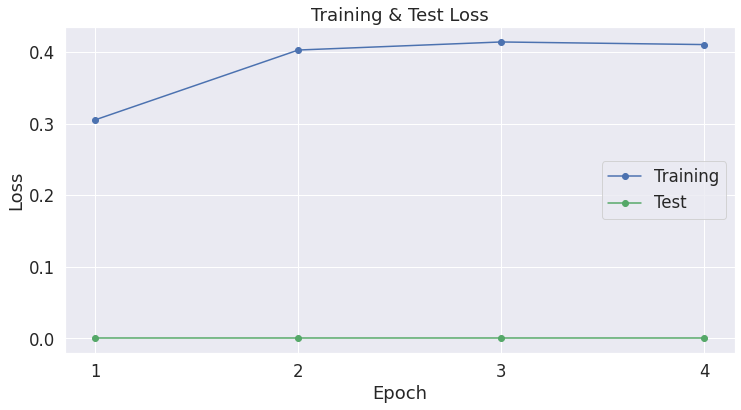

In [71]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Test Loss'], 'g-o', label="Test")

# Label the plot.
plt.title("Training & Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()